In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
using_duckdb = 0
if using_duckdb:
    import duckdb
    db_conn = duckdb.connect("lyft.db")
    cursor = db_conn.cursor()

In [3]:
first_time = 0
if first_time:

    agents_df = pd.read_csv("agents.csv")
    scenes_df = pd.read_csv("scenes.csv")
    frames_df = pd.read_csv("frames.csv")

    agents_df.to_sql('agents', db_conn, if_exists='replace', index = False)
    scenes_df.to_sql('scenes', db_conn, if_exists='replace', index = False)
    frames_df.to_sql('frames', db_conn, if_exists='replace', index = False)

In [4]:
query = """
DROP TABLE IF EXISTS lyft_data;
CREATE TABLE IF NOT EXISTS lyft_data AS
WITH 
scenes1 AS 
(
SELECT 
S0.*
FROM 
scenes S0),

frames1 AS 
(
SELECT 
F0.scene_index
, F0.frame_index
, 0 as track_id
, ROUND(F0.ego_translation_x, 4) as centroid_x
, ROUND(F0.ego_translation_y, 4) as centroid_y
, 4.87 as extent_x
, 1.85 as extent_y
, 1.8 as extent_z
, 9.0095 as area
, 16.2171 as volume
, NULL as velocity_x
, NULL as velocity_y
, NULL as yaw
, 1 as label_car
, 0 as label_unk
, 0 as label_ped
, 0 as label_cyc
FROM 
frames F0),


agents1 AS 
(
SELECT 
F1.scene_index
, A0.frame_index
, A0.track_id
, ROUND(A0.centroid_x, 4) as centroid_x
, ROUND(A0.centroid_y, 4) as centroid_y
, A0.extent_x
, A0.extent_y
, A0.extent_z
, (A0.extent_x * A0.extent_y) as area
, (A0.extent_x * A0.extent_y * A0.extent_z) as volume
, A0.velocity_x
, A0.velocity_y
, A0.yaw
, A0.PERCEPTION_LABEL_CAR as label_car
, A0.PERCEPTION_LABEL_UNKNOWN as label_unk
, A0.PERCEPTION_LABEL_PEDESTRIAN as label_ped
, A0.PERCEPTION_LABEL_CYCLIST as label_cyc
FROM 
frames1 F1 LEFT OUTER JOIN agents A0 ON F1.frame_index = A0.frame_index
)

, Tbl0 AS (
SELECT F1.* FROM frames1 F1
UNION ALL
SELECT A1.* FROM agents1 A1
)

,Tbl0_testing as (
SELECT
T0.scene_index
, COUNT(*)
FROM Tbl0 T0
WHERE T0.track_id = 0
GROUP BY T0.scene_index
)


, Tbl1_skips as (
SELECT
T0.*
--, ROW_NUMBER() OVER (PARTITION BY T0.scene_index, T0.track_id ORDER BY T0.scene_index, T0.track_id, T0.frame_index) as rown
, LAG(T0.frame_index) OVER (PARTITION BY T0.scene_index, T0.track_id ORDER BY T0.scene_index, T0.track_id, T0.frame_index) as frame_index0
FROM Tbl0 T0
)

, Tbl1 as (
SELECT
T0.*
, (T0.frame_index - T0.frame_index0) as skip
FROM Tbl1_skips T0
)

, framerate as (
SELECT
T1.*
FROM Tbl1 T1
--WHERE T1.frame_index % 20 = 0
)

, centroid_testing as (
SELECT 
AVG(CASE WHEN FR0.centroid_x IS NULL THEN 1 ELSE 0 END) 
, AVG(CASE WHEN FR0.centroid_y IS NULL THEN 1 ELSE 0 END)
FROM framerate FR0
)

, lag_centroid_null as (
SELECT
FR0.*
, LAG(FR0.centroid_x,1) OVER (PARTITION BY FR0.scene_index, FR0.track_id ORDER BY FR0.scene_index, FR0.track_id, FR0.frame_index) as centroid_x1n
, LAG(FR0.centroid_y,1) OVER (PARTITION BY FR0.scene_index, FR0.track_id ORDER BY FR0.scene_index, FR0.track_id, FR0.frame_index) as centroid_y1n
FROM framerate FR0
)

-- imputing with previous centroids will mean standstill or create a bunch of initial velocities with 0
, lag_centroid as (
SELECT
LCN0.*
, COALESCE(LCN0.centroid_x1n, LCN0.centroid_x) as centroid_x1
, COALESCE(LCN0.centroid_y1n, LCN0.centroid_y) as centroid_y1
FROM lag_centroid_null LCN0
)

-- 
, lag_centroid_testing as (
SELECT 
COUNT(DISTINCT CONCAT(LC0.scene_index, LC0.track_id))
, SUM(CASE WHEN LC0.centroid_x1 IS NULL THEN 1 ELSE 0 END) 
, SUM(CASE WHEN LC0.centroid_y1 IS NULL THEN 1 ELSE 0 END)
FROM lag_centroid LC0
)

-- exagerrate velocity to prevent explosive quotients
, make_velocity as (
SELECT
LC0.*
, (LC0.centroid_x1 - LC0.centroid_x)*5 as velocity_x0
, (LC0.centroid_y1 - LC0.centroid_y)*5 as velocity_y0
, SQRT((POW((LC0.centroid_x1 - LC0.centroid_x)*5, 2) + POW((LC0.centroid_y1 - LC0.centroid_y)*5, 2))) as norm0
FROM 
lag_centroid LC0
)

, velocity_testing as (
SELECT 
COUNT(DISTINCT CONCAT(MV0.scene_index, MV0.track_id))
, SUM(CASE WHEN MV0.velocity_x0 IS NULL THEN 1 ELSE 0 END) 
, SUM(CASE WHEN MV0.velocity_y0 IS NULL THEN 1 ELSE 0 END)
, SUM(CASE WHEN MV0.norm0 IS NULL THEN 1 ELSE 0 END)
FROM make_velocity MV0
)

, lag_velocity_null as (
SELECT
MV0.*
, LAG(MV0.velocity_x0,1) OVER (PARTITION BY MV0.scene_index, MV0.track_id ORDER BY MV0.scene_index, MV0.track_id, MV0.frame_index) as velocity_x1n
, LAG(MV0.velocity_y0,1) OVER (PARTITION BY MV0.scene_index, MV0.track_id ORDER BY MV0.scene_index, MV0.track_id, MV0.frame_index) as velocity_y1n
, LAG(MV0.norm0,1) OVER (PARTITION BY MV0.scene_index, MV0.track_id ORDER BY MV0.scene_index, MV0.track_id, MV0.frame_index) as norm1n
FROM make_velocity MV0
)

-- unlike centroids, in this case, it is totally fine to use 0 as a last resort imputation
, lag_velocity as (
SELECT
LVN0.*
, COALESCE(LVN0.velocity_x1n, LVN0.velocity_x0, 0.0) as velocity_x1
, COALESCE(LVN0.velocity_y1n, LVN0.velocity_y0, 0.0) as velocity_y1
, COALESCE(LVN0.norm1n, LVN0.norm0, 0) as norm1
FROM lag_velocity_null LVN0
)

, lag_velocity_testing as (
SELECT 
COUNT(DISTINCT CONCAT(LV0.scene_index, LV0.track_id))
, SUM(CASE WHEN LV0.velocity_x0 IS NULL THEN 1 ELSE 0 END) as vx0
, SUM(CASE WHEN LV0.velocity_y0 IS NULL THEN 1 ELSE 0 END) as vy0
, SUM(CASE WHEN LV0.norm0 IS NULL THEN 1 ELSE 0 END) as n0
, SUM(CASE WHEN LV0.velocity_x1 IS NULL THEN 1 ELSE 0 END) as vx1
, SUM(CASE WHEN LV0.velocity_y1 IS NULL THEN 1 ELSE 0 END) as vy1
, SUM(CASE WHEN LV0.norm1 IS NULL THEN 1 ELSE 0 END) as vn1
FROM lag_velocity LV0
)


, make_unit_vectors as (
SELECT
LV0.*
, (LV0.velocity_x0/LV0.norm0) as velocity_x0u
, (LV0.velocity_y0/LV0.norm0) as velocity_y0u
, (LV0.velocity_x1/LV0.norm1) as velocity_x1u
, (LV0.velocity_y1/LV0.norm1) as velocity_y1u
FROM lag_velocity LV0
)


, unit_vectors_testing as (
SELECT
MIN(velocity_x0u), MAX(velocity_x0u)
, MIN(velocity_y0u), MAX(velocity_y0u)
, MIN(velocity_x1u), MAX(velocity_x1u)
, MIN(velocity_y1u), MAX(velocity_y1u)
, AVG(CASE WHEN velocity_x0u BETWEEN -1 AND 1 THEN 1 ELSE 0 END)
, AVG(CASE WHEN velocity_y0u BETWEEN -1 AND 1 THEN 1 ELSE 0 END)
, AVG(CASE WHEN velocity_x1u BETWEEN -1 AND 1 THEN 1 ELSE 0 END)
, AVG(CASE WHEN velocity_y1u BETWEEN -1 AND 1 THEN 1 ELSE 0 END)
FROM make_unit_vectors MUV0
)

, make_dotprod_crossprod as (
SELECT
MUV0.*
, ROUND(((MUV0.velocity_x0u * MUV0.velocity_x1u) + (MUV0.velocity_y0u * MUV0.velocity_y1u)),8) AS dotprod
, ROUND(((MUV0.velocity_x0u * MUV0.velocity_y1u) - (MUV0.velocity_y0u * MUV0.velocity_x1u)),8) AS crossprod
FROM make_unit_vectors MUV0
)

, make_dotprod_crossprod_testing as (
SELECT min(MDPCP0.dotprod), min(MDPCP0.crossprod), max(MDPCP0.dotprod), max(MDPCP0.crossprod)
FROM make_dotprod_crossprod MDPCP0
)

, make_yaw_temp as (
SELECT
MDPCP0.*
, ACOS(MDPCP0.dotprod) as arccos_dotprod
, CAST((CASE WHEN MDPCP0.crossprod >= 0 THEN 1.0 ELSE -1.0 END) AS DOUBLE) as sign_crossprod
FROM make_dotprod_crossprod MDPCP0
)

, make_yaw_temp_testing as (
SELECT 
--min(MYT0.arccos_dotprod), min(MYT0.arccos_dotprod), max(MYT0.sign_crossprod), max(MYT0.sign_crossprod)
AVG(MYT0.arccos_dotprod), AVG(MYT0.sign_crossprod)
FROM make_yaw_temp MYT0
)

, make_yaw as (
SELECT
MYT0.*
, (MYT0.arccos_dotprod * MYT0.sign_crossprod) as yaw0
FROM make_yaw_temp MYT0
)

, yaw_testing as (
SELECT 
COUNT(DISTINCT CONCAT(MY0.scene_index, MY0.track_id))
, SUM(CASE WHEN MY0.yaw0 IS NULL THEN 1 ELSE 0 END) 
FROM make_yaw MY0
)

, final_yaw as (
SELECT 
MY0.scene_index
, MY0.frame_index
, MY0.track_id
, MY0.frame_index0
, MY0.skip
, MY0.centroid_x
, MY0.centroid_y
, MY0.extent_x
, MY0.extent_y
, MY0.extent_z
, MY0.area
, MY0.volume
--, COALESCE(MY0.velocity_x0, MY0.velocity_x) as velocity_x
--, COALESCE(MY0.velocity_y0, MY0.velocity_y) as velocity_y
--, COALESCE(MY0.yaw0, MY0.yaw,0) as yaw
, MY0.velocity_x as velocity_x_orig
, MY0.velocity_y as velocity_y_orig
, MY0.yaw as yaw_orig
, MY0.velocity_x0 as velocity_x
, MY0.velocity_y0 as velocity_y
, MY0.norm0 as norm
, MY0.yaw0 as yaw
, (DEGREES(MY0.yaw0)+180+45)%360 as yaw_shifted
--, FLOOR((DEGREES(MY0.yaw0)+180)/(360/16)) as yaw_eqw
, MY0.label_car
, MY0.label_unk
, MY0.label_ped
, MY0.label_cyc
FROM make_yaw MY0
)

, lyft_data0 as (
SELECT T0.* 
, COALESCE(T0.yaw, T0.yaw_orig) as yaw_unskipped_imputed
, NTILE(4) OVER (ORDER BY T0.yaw_shifted) as yaw_eqn
, NTILE(4) OVER (ORDER BY T0.norm) as norm_eqn
FROM final_yaw T0
)

, lyft_data as (
SELECT T0.* 
, NTILE(4) OVER (ORDER BY T0.yaw_shifted) as yaw_eqn_with_null
, NTILE(4) OVER (ORDER BY T0.norm) as norm_eqn_with_null
FROM lyft_data0 T0
WHERE T0.norm != 0
UNION ALL
SELECT T0.* 
, 0 as yaw_eqn_with_null
, 0 as norm_eqn_with_null
FROM lyft_data0 T0
WHERE T0.norm = 0
)

-- because of the modulo, we cannot coalesce the old velocity or yaw columns with the new ones, they are fully differently calculated.

SELECT *
FROM  lyft_data
ORDER BY scene_index, track_id, frame_index
;
"""
path_file_lyft_data_orig = "lyft_data_framerate1r4_orig.csv"
path_file_lyft_data_new = "lyft_data_framerate1r4.csv"

first_time = using_duckdb
if first_time:
    cursor = db_conn.cursor()
    cursor.sql(query)
    db_conn.commit()
    
    df_name = "lyft_data"
    df_result = cursor.sql("SELECT * FROM {0}".format(df_name))
    df_orig = pd.DataFrame(df_result.fetchall())

    columns_result = cursor.sql("SELECT COLUMN_NAME FROM system.Information_schema.columns where Table_name like '{0}'".format(df_name))
    columns = pd.DataFrame(columns_result.fetchall())

    df_orig.columns = columns.iloc[:,0].values.tolist()
    
    df_orig.to_csv(path_file_lyft_data_orig,index=False)
    df = df_orig.copy()
else:
    df_orig = pd.read_csv(path_file_lyft_data_orig)
    df = df_orig.copy()
    print(df.shape)

(1975080, 29)


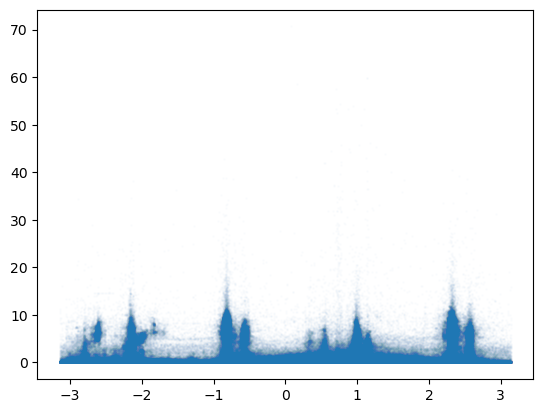

In [5]:
plt.scatter(df["yaw_orig"],df["norm"],alpha=0.01,s=1)

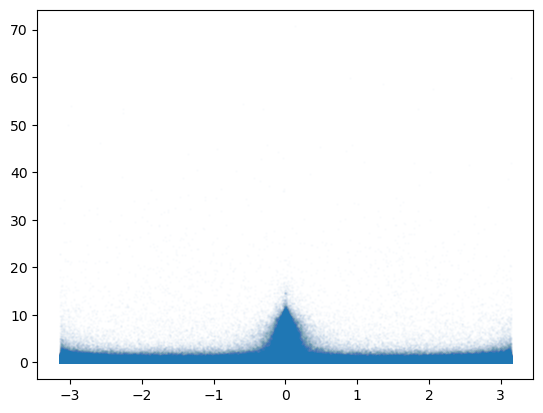

In [6]:
plt.scatter(df["yaw"],df["norm"],alpha=0.01,s=1)

## Checking Null

In [7]:
df.isnull().mean(axis=0)

scene_index              0.000000
frame_index              0.000000
track_id                 0.000000
frame_index0             0.063574
skip                     0.063574
centroid_x               0.000000
centroid_y               0.000000
extent_x                 0.000000
extent_y                 0.000000
extent_z                 0.000000
area                     0.000000
volume                   0.000000
velocity_x_orig          0.012575
velocity_y_orig          0.012575
yaw_orig                 0.012575
velocity_x               0.000000
velocity_y               0.000000
norm                     0.000000
yaw                      0.129573
yaw_shifted              0.129573
label_car                0.000000
label_unk                0.000000
label_ped                0.000000
label_cyc                0.000000
yaw_unskipped_imputed    0.003982
yaw_eqn                  0.000000
norm_eqn                 0.000000
yaw_eqn_with_null        0.000000
norm_eqn_with_null       0.000000
dtype: float64

In [8]:
print((df["track_id"]==0).mean())

0.012575186827875326


* **The null placeholders for track-id=0 is why the original yaw and velocity columns have a null percentage.**
* **Notice the percentage of track-id=0 is the same value as that null percentage 0.01257**
* **This means that for the other track-id's, the original yaw and velocity columns are safe to use without any missing data**

## Checking OnRoad
* **By Raster**
* **By Polygons (crosswalk and lane-coords)**
    * If with Polygons, can also check crosswalks, if forward-trajectory of agent intersects the buffer or if agent is within buffer

In [9]:
import shapely
import shapely.geometry


### Checking Lanes

In [10]:
from PIL import Image
def add_roadmap_adjuster_x():
    return 1285
def add_roadmap_adjuster_y():
    return 2770
def vertices_adjustment(row_vertices, shift_x=None, shift_y=None):
    # Either shifting to roadmap, or for agent
    #print(row_vertices)
    shift_x = add_roadmap_adjuster_x()
    shift_y = add_roadmap_adjuster_y()
    row_vertices[:,0] += shift_x
    row_vertices[:,1] += shift_y
    return row_vertices
roadmap = Image.open("palo_alto_proper_blurred.png").convert("L")
roadmap_arr = np.array(roadmap)[::-1]
roadmap_arr_bounded = roadmap_arr / 255 # bounded between 0 and 1
roadmap_arr_bounded_inverted = 1-roadmap_arr_bounded
roadmap_raster = roadmap_arr_bounded_inverted
#)!=0

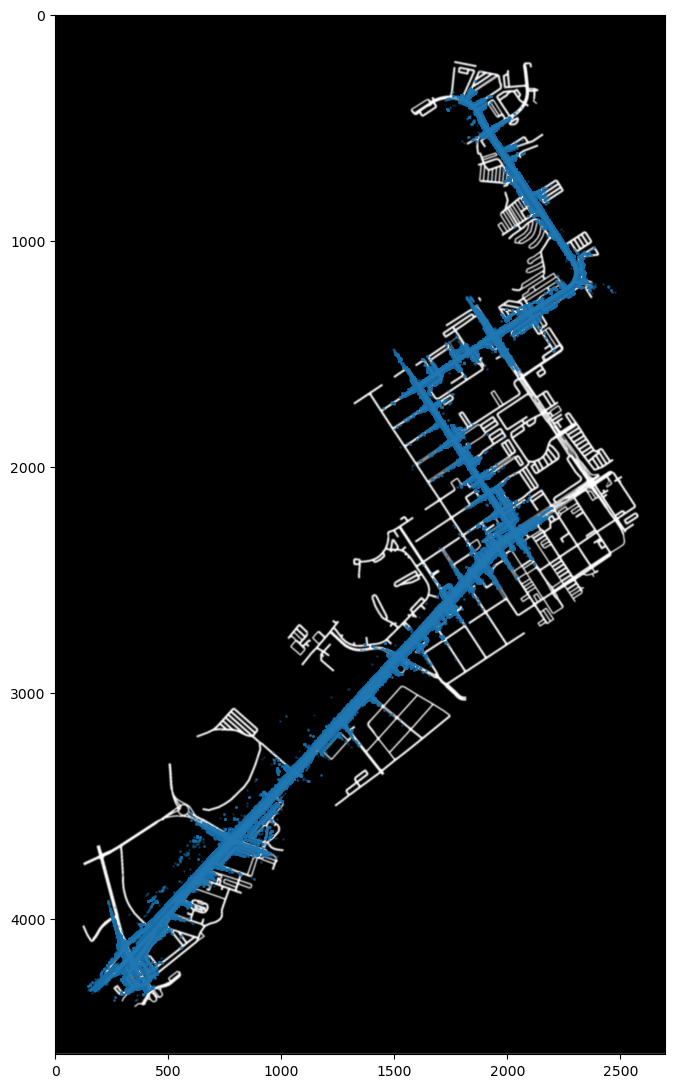

In [11]:
fig, ax = plt.subplots(figsize=(23,13.5))
ax.imshow(roadmap_raster, cmap="gray")
ax.scatter(df["centroid_x"]+add_roadmap_adjuster_x(), df["centroid_y"]+add_roadmap_adjuster_y(),s=1,alpha=0.1)

In [12]:
def check_on_road(centroid_x,centroid_y):
    x = int(centroid_x)+add_roadmap_adjuster_x()
    y = int(centroid_y)+add_roadmap_adjuster_y()
    pixel = roadmap_raster[y][x]
    return pixel
df["on_road"] = df.apply(lambda df: check_on_road(df["centroid_x"], df["centroid_y"]), axis=1)

In [13]:
np.mean(df[((df["scene_index"]==112)# & (df["track_id"]==0)
           )]["on_road"]>0.3)

0.5707813566685285

In [14]:
np.mean(df[((df["scene_index"]==112) & (df["track_id"]==0))]["on_road"]>0.3)

0.8266129032258065

In [15]:
# Successfully configured roadmap with agent coordinates data

### Checking Crosswalks

In [16]:
crosswalks_df = pd.read_csv("crosswalks.csv")
crosswalks_df["cw_coord_x"] /= 2
crosswalks_df["cw_coord_y"] /= 2

crosswalks_df["intersection_id"].value_counts().value_counts()

count
4     581
6      30
5      21
7      18
8      10
9       2
13      1
Name: count, dtype: int64

In [17]:
crosswalks_df["intersection_id"].value_counts()

intersection_id
481    13
296     9
31      9
178     8
27      8
       ..
238     4
239     4
240     4
241     4
662     4
Name: count, Length: 663, dtype: int64

(<Figure size 640x480 with 1 Axes>, <Axes: >)

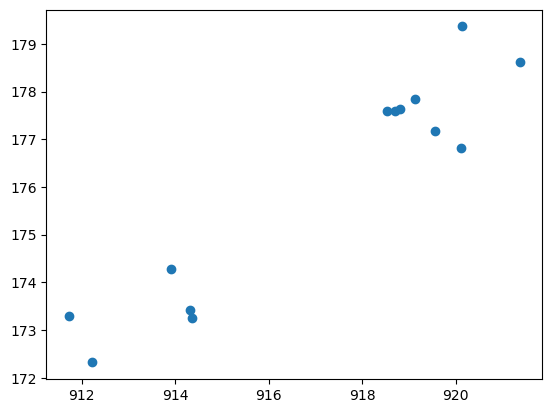

In [18]:
def show_scatterplot_intersection_ids(temp_intersection_ids_to_scatterplot):
    temp_crosswalks_df = crosswalks_df[crosswalks_df["intersection_id"].isin(temp_intersection_ids_to_scatterplot)]
    fig, ax = plt.subplots()
    ax.scatter(temp_crosswalks_df["cw_coord_x"],temp_crosswalks_df["cw_coord_y"])
    return fig, ax
show_scatterplot_intersection_ids([481] )

In [19]:
import shapely.geometry

def build_shapely_point(x,y):
    try:
        return shapely.Point(x, y)
    except:
        return shapely.geometry.Point(x, y)
build_point = np.vectorize(build_shapely_point)
point_column = crosswalks_df.apply(lambda df: build_point(df["cw_coord_x"], df["cw_coord_y"]), axis=1)
crosswalks_df["cw_point"] = point_column
intersection_df = crosswalks_df.groupby(["intersection_id"], as_index=False).agg({"cw_point": list})

C:\Users\Benson\anaconda3\envs\lyft_summer_2023\lib\site-packages\numpy\lib\function_base.py:2433: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  otypes = ''.join([asarray(outputs[_k]).dtype.char
C:\Users\Benson\anaconda3\envs\lyft_summer_2023\lib\site-packages\numpy\lib\function_base.py:2365: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return self._vectorize_call(func=func, args=vargs)


In [20]:
def build_shapely_polygon(points):
    try:
        return shapely.Polygon(points+points[0])
    except:
        return shapely.geometry.Polygon(points+points[0])

build_polygon = build_shapely_polygon
cw_polygon_column = intersection_df["cw_point"].apply(build_polygon)
intersection_df["cw_polygon"] = cw_polygon_column

**Visualizing polygonal validity of irregular crosswalks**

In [21]:
viztest_irregular_crosswalks_one_by_one = 0
if viztest_irregular_crosswalks_one_by_one:
    crosswalks_df_coord_counts = crosswalks_df["intersection_id"].value_counts()#>4

    intersection_ids_above_4_points = list(crosswalks_df_coord_counts.index[
        np.where(crosswalks_df["intersection_id"].value_counts()>4)[0]
    ]) # cross walks with more than 4 points


    crosswalks_df["intersection_id"].value_counts()>4

    for intersection_id in intersection_ids_above_4_points:
        #intersection_id = 0
        polygon_i = intersection_df[intersection_df["intersection_id"].isin([intersection_id])]["cw_polygon"].values[0]
        x,y = polygon_i.exterior.xy
        fig, ax = plt.subplots()
        ax.plot(x,y)

In [22]:
viztest_crosswalks_altogether = 0

if viztest_crosswalks_altogether:
    fig, ax = plt.subplots()
    ax.imshow(roadmap_arr, cmap="gray")

    for intersection_id in list(intersection_df["intersection_id"]):
        #intersection_id = 0
        polygon_i = intersection_df[intersection_df["intersection_id"].isin([intersection_id])]["cw_polygon"].values[0]
        x,y = polygon_i.exterior.xy
        ax.plot(x,y)

In [23]:
viztest_crosswalks_altogether_zoomed_in = 0


if viztest_crosswalks_altogether_zoomed_in:
    fig, ax = plt.subplots(figsize=(20,20))

    ax.imshow(roadmap_arr, cmap="gray")
    ax.set_xlim((1500,2000))
    ax.set_ylim((2300,2700))


    for intersection_id in list(intersection_df["intersection_id"]):
        #intersection_id = 0
        polygon_i = intersection_df[intersection_df["intersection_id"].isin([intersection_id])]["cw_polygon"].values[0]
        x,y = polygon_i.exterior.xy
        ax.plot(x,y,c="red")

In [24]:
# Successfully validated crosswalk polygons

In [25]:
def get_shapely_buffer(polygon):
    try:
        return polygon.buffer(5)
    except:
        return shapely.geometry.polygon.buffer(polygon, 5)
get_buffer = np.vectorize(get_shapely_buffer)
intersection_df["cw_polygon_buffer"] = get_buffer(intersection_df["cw_polygon"])

In [26]:
viztest_crosswalks_buffers_altogether_zoomed_in = 0

if viztest_crosswalks_buffers_altogether_zoomed_in:
    fig, ax = plt.subplots(figsize=(20,20))

    ax.imshow(roadmap_arr, cmap="gray")
    ax.set_xlim((1500,2000))
    ax.set_ylim((2300,2700))


    for intersection_id in list(intersection_df["intersection_id"]):
        #intersection_id = 0
        polygon_i = intersection_df[intersection_df["intersection_id"].isin([intersection_id])]["cw_polygon_buffer"].values[0]
        x,y = polygon_i.exterior.xy
        ax.plot(x,y,c="red")

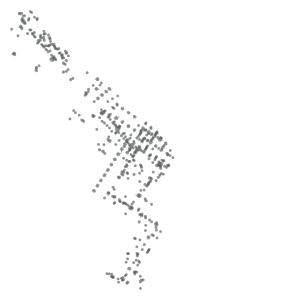

In [27]:
import shapely.ops
crosswalks_layer = shapely.ops.unary_union(intersection_df["cw_polygon_buffer"] )
crosswalks_layer

In [28]:
import rasterio.features

viztest_crosswalks_rasters = 0
crosswalks_raster = rasterio.features.rasterize([crosswalks_layer], out_shape=(4600, 2700))
if viztest_crosswalks_rasters:
    # https://stackoverflow.com/questions/67708224/shapely-polygon-to-binary-mask
    fig, ax = plt.subplots()
    ax.imshow(crosswalks_raster!=0, cmap="gray")
    ax.scatter(df["centroid_x"]+add_roadmap_adjuster_x(), df["centroid_y"]+add_roadmap_adjuster_y(),s=1,alpha=0.01)

In [29]:
assert set(list(np.ravel(crosswalks_raster))) == {0, 1}

In [30]:
def check_on_crosswalks(centroid_x,centroid_y):
    x = int(centroid_x)+add_roadmap_adjuster_x()
    y = int(centroid_y)+add_roadmap_adjuster_y()
    pixel = crosswalks_raster[y][x]
    return pixel
df["on_crosswalks"] = df.apply(lambda df: check_on_crosswalks(df["centroid_x"], df["centroid_y"]), axis=1)

#23,13.5

fig, ax = plt.subplots(1,3, figsize=(60,20))
ax[0].imshow(roadmap_arr_bounded, cmap="gray")

In [31]:
viztest_layered_traffic_crosswalks = 0
if viztest_layered_traffic_crosswalks:
    fig, ax = plt.subplots(1,3, figsize=(40,25))
    ax[0].imshow(roadmap_raster, cmap="gray")
    ax[1].imshow(roadmap_raster, cmap="gray")
    ax[2].imshow(roadmap_raster, cmap="gray")
    viztest_crosswalks_altogether = 1
    if viztest_crosswalks_altogether:
        for intersection_id in list(intersection_df["intersection_id"]):
            #intersection_id = 0
            polygon_i = intersection_df[intersection_df["intersection_id"].isin([intersection_id])]["cw_polygon"].values[0]
            x,y = polygon_i.exterior.xy
            ax[1].plot(x,y,c="red")
            ax[2].plot(x,y,c="red",alpha=0.75)
    ax[2].imshow(roadmap_raster, cmap="gray")
    ax[2].scatter(df["centroid_x"]+add_roadmap_adjuster_x(), df["centroid_y"]+add_roadmap_adjuster_y(),s=1,alpha=0.05,c="blue")

In [32]:
viztest_crosswalks_buffer_comparison = 0
if viztest_crosswalks_buffer_comparison:

    fig, ax = plt.subplots(1,2,figsize=(35,20))

    ax[0].imshow(roadmap_raster, cmap="gray")
    ax[0].set_xlim((1500,2000))
    ax[0].set_ylim((2300,2700))
    ax[1].imshow(roadmap_raster, cmap="gray")
    ax[1].set_xlim((1500,2000))
    ax[1].set_ylim((2300,2700))

    viztest_crosswalks_altogether_zoomed_in = 1
    if viztest_crosswalks_altogether_zoomed_in:

        for intersection_id in list(intersection_df["intersection_id"]):
            #intersection_id = 0
            polygon_i = intersection_df[intersection_df["intersection_id"].isin([intersection_id])]["cw_polygon"].values[0]
            x,y = polygon_i.exterior.xy
            ax[0].plot(x,y,c="red")

            polygon_i = intersection_df[intersection_df["intersection_id"].isin([intersection_id])]["cw_polygon_buffer"].values[0]
            x,y = polygon_i.exterior.xy
            ax[1].plot(x,y,c="red")

## Checking Agent Type

In [33]:
known_agent_type_column_names = ["label_car","label_ped","label_cyc"]
agent_type_column_names = known_agent_type_column_names + ["label_unk"]
agent_type_column = np.argmax(df[agent_type_column_names].values, axis=1)
agent_type_name_column = pd.Series(agent_type_column).apply(lambda x: agent_type_column_names[x])
df["label"] = agent_type_name_column
pd.Series(agent_type_name_column).value_counts(normalize=True).to_frame()

,proportion
label_unk,0.654065
label_car,0.318129
label_ped,0.022771
label_cyc,0.005036


In [34]:
df.groupby(["label"]).agg({"on_road": np.mean,
                           "on_crosswalks": np.mean})

,on_road,on_crosswalks
label,,
label_car,0.589208,0.090752
label_cyc,0.610146,0.434044
label_ped,0.440207,0.335972
label_unk,0.417728,0.109136


### Checking consistency of Agent Type

In [35]:
agent_lead_type_consistency = df.groupby(["scene_index","track_id","label"], as_index=False)["frame_index"].count() 
agent_lead_type_consistency_agg = agent_lead_type_consistency.groupby(
    ["scene_index","track_id"], as_index=False)["frame_index"].count()
agent_lead_type_perc = np.mean(agent_lead_type_consistency_agg["frame_index"]==1)

print(f"{agent_lead_type_perc} of all track ids have the same leading agent type throughout 100% of their frames")

0.9785846261667357 of all track ids have the same leading agent type throughout 100% of their frames


In [36]:
agg_funcs_list = np.mean#+ [np.std]
agent_type_consistency_aggdict = {
    "label_car": agg_funcs_list,
    "label_ped": agg_funcs_list,
    "label_cyc": agg_funcs_list,
    "label_unk": agg_funcs_list,
}
agent_type_consistency_agg = df.groupby(["scene_index","track_id"], as_index=False).agg(agent_type_consistency_aggdict)

In [37]:
agent_type_consistency_agg.iloc[20:40,:]

,scene_index,track_id,label_car,label_ped,label_cyc,label_unk
20,112,20,1.00000,0.000000,0.000000,0.000000
21,112,21,1.00000,0.000000,0.000000,0.000000
22,112,22,1.00000,0.000000,0.000000,0.000000
23,112,23,1.00000,0.000000,0.000000,0.000000
24,112,24,1.00000,0.000000,0.000000,0.000000
25,112,25,1.00000,0.000000,0.000000,0.000000
26,112,26,0.00000,0.038874,0.947042,0.014085
27,112,27,1.00000,0.000000,0.000000,0.000000
28,112,28,1.00000,0.000000,0.000000,0.000000
29,112,29,1.00000,0.000000,0.000000,0.000000


In [38]:
agent_type_consistency_agg["label"] = agent_type_name_column

In [39]:
rowwise_std_of_columnwise_label_means_column = np.std(
    agent_type_consistency_agg[agent_type_column_names].values,axis=1
)
ideal_rowwise_std_of_columnwise_label_means = np.std([1, 0, 0, 0]) 
# or np.std([0,1,0,0]), or np.std([0,0,1,0]), or np.std([0,0,0,1]), ... any order can work
label_consistency_column = rowwise_std_of_columnwise_label_means_column==ideal_rowwise_std_of_columnwise_label_means
agent_type_consistency_agg["label_consistency"] = label_consistency_column 

In [40]:
consistent_agent_types_percent = np.mean(
    agent_type_consistency_agg["label_consistency"]
)
print(f"The Percent of Scene-Track-id's with Perfectly Consistent Agent Types is {consistent_agent_types_percent}")

The Percent of Scene-Track-id's with Perfectly Consistent Agent Types is 0.9773979803128285


* **The Percent of Scene-Track-id's with perfectly consistent agent types is very good (97%)**
* **And as the table below shows, all agent types have a good label consistency**

In [41]:
agent_type_consistency_agg.groupby(["label"]).agg({"label_consistency": np.mean})

,label_consistency
label,
label_car,0.978405
label_cyc,0.976548
label_ped,0.975356
label_unk,0.976706


## Checking Norm
* **Validity of Norm**

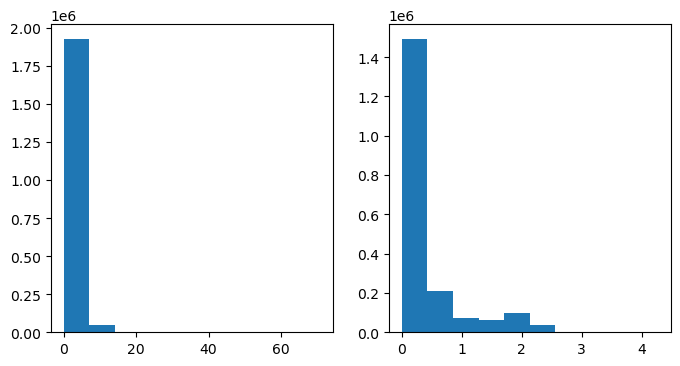

In [42]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
_ = axs[0].hist(df["norm"])
_ = axs[1].hist((df["norm"]).apply(np.log1p))

In [43]:
df.groupby(["norm_eqn_with_null"],as_index=False).agg({"norm": [min,max]})

norm_eqn_with_null      norm           
                           min        max
0                  0  0.000000   0.000000
1                  1  0.000500   0.049992
2                  2  0.049992   0.166827
3                  3  0.166831   0.573536
4                  4  0.573537  70.671412

In [44]:
df["norm_eqn_with_null"].value_counts()

norm_eqn_with_null
4    459382
3    459382
2    459382
1    459382
0    137552
Name: count, dtype: int64

In [45]:
df.groupby(["norm_eqn"],as_index=False).agg({"norm": [min,max]})

norm_eqn      norm           
                 min        max
0        1  0.000000   0.038161
1        2  0.038161   0.139257
2        3  0.139257   0.514409
3        4  0.514410  70.671412

In [46]:
df["norm_eqn"].value_counts()

norm_eqn
1    493770
4    493770
3    493770
2    493770
Name: count, dtype: int64

In [47]:
df.groupby(["label"]).agg({"norm":[np.mean,np.median, np.max,np.min]})

norm                          
               mean    median        max  min
label                                        
label_car  2.060421  0.478930  42.746357  0.0
label_cyc  1.229620  0.573109  18.500349  0.0
label_ped  0.465747  0.455619  10.611000  0.0
label_unk  0.253617  0.092512  70.671412  0.0

In [48]:
df["norm/volume"] = (df["norm"]+1)/(df["volume"]+1)
df["norm/area"] = (df["norm"]+1)/(df["area"]+1)

## Checking Dimensions
* **Validity of Dimensions**
    * **Impossibly low/high dimensions, validity of sidelength proportions (assuming dimensions are reliable)**
    * **Impossibly high speed.**
* **Consistency of Dimensions**

In [49]:
df["extent_x/extent_y"] = (
    (df["extent_x"]+1)/(df["extent_y"]+1))
df["extent_y/extent_x"] = (
    (df["extent_y"]+1)/(df["extent_x"]+1))
df["rectangular"] = (
    #(df_agent_type_categorizer["extent_y"]**2)-(df_agent_type_categorizer["extent_x"]**2)
    (np.max(df[["extent_x","extent_y"]],axis=1)+1
    )/(np.min(df[["extent_x","extent_y"]],axis=1)+1)
)
df["area/extent_z"] = (df["area"]+1)/df["extent_z"]

### Checking Validity of Dimensions
* It's time to trim off the rows with impossible dimensions
* According to research, the max dimensions allowed for a road vehicle is 19.8 meters-long and 2.6 meters-wide.
* The problem is that the dataset's metadata never specified if extent_x or extent_y is the car's width or length, or even those designations are even consistent throughout.
* So for a given row, if we see the extent_x is longer than the extent_y, we can assume extent_x is the length that needs to be below 19.8 meters and the extent_y is the wdidth that needs to be below 2.6 meters. And vice versa if extent_y is longer than extent_x.

In [50]:
df["invalid_dims"] = 0
df.loc[((df["extent_x"]>df["extent_y"]) & (df["extent_x"] > 19.8)),"invalid_dims"] = 1
df.loc[((df["extent_x"]>df["extent_y"]) & (df["extent_y"] > 2.6)),"invalid_dims"] = 1
df.loc[((df["extent_y"]>df["extent_x"]) & (df["extent_y"] > 19.8)),"invalid_dims"] = 1
df.loc[((df["extent_y"]>df["extent_x"]) & (df["extent_x"] > 2.6)),"invalid_dims"] = 1

In [51]:
np.mean(df["invalid_dims"])

0.030531421512040018

* **There isn't a lot of agents with invalid dimensions...**

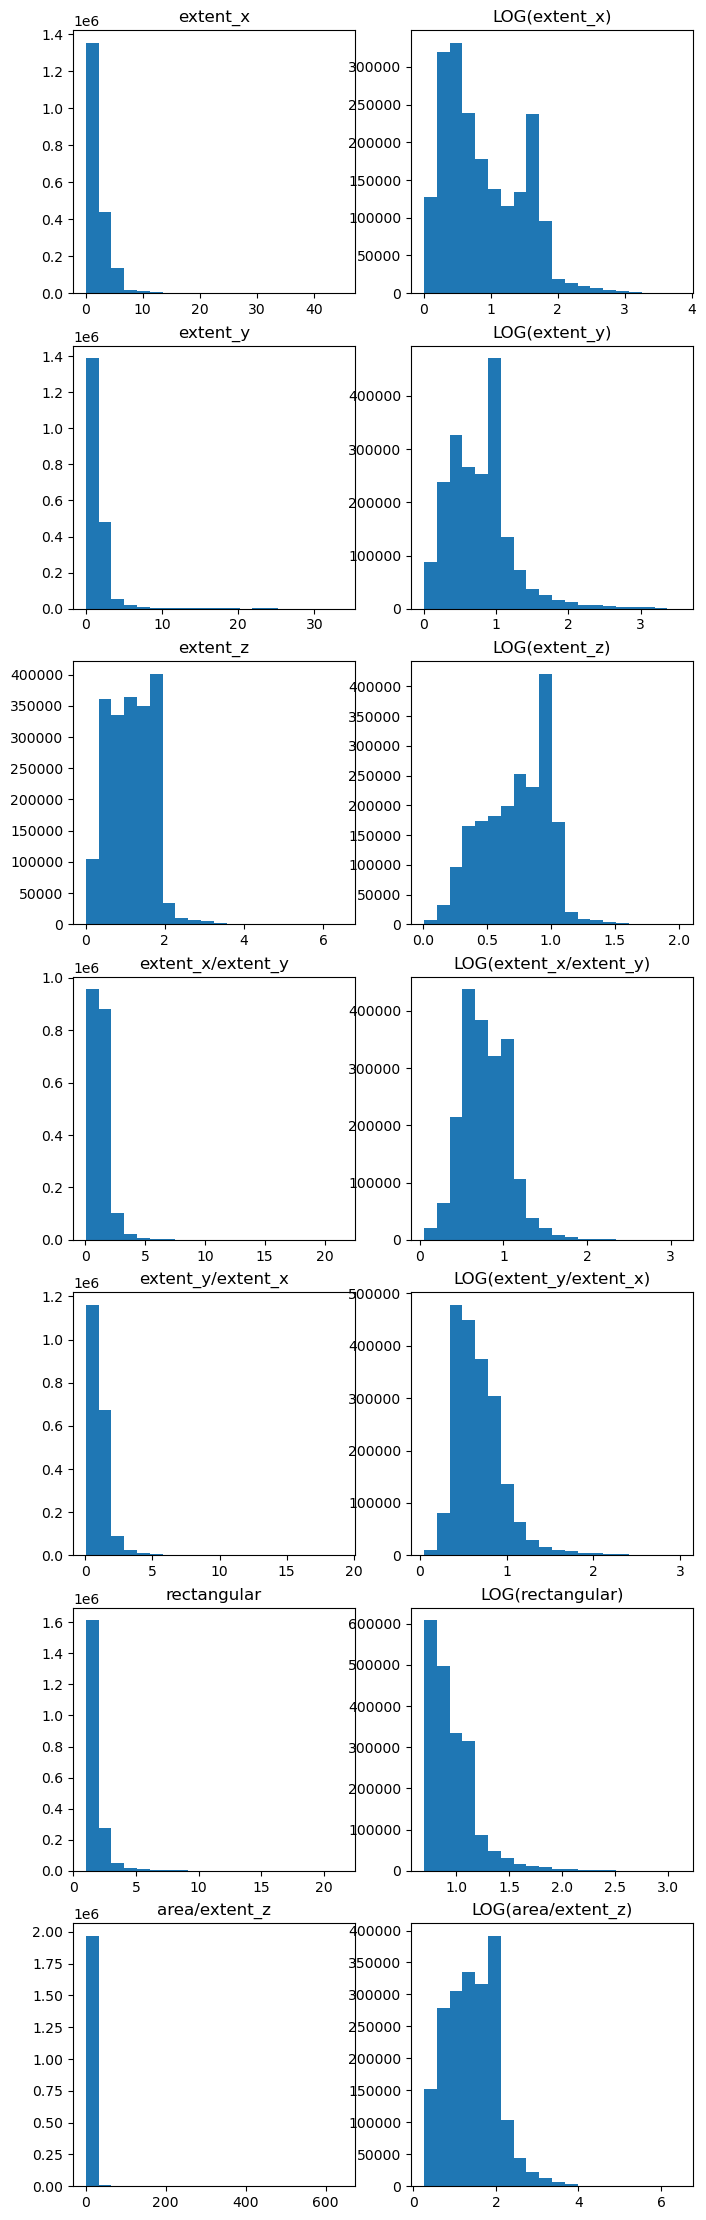

In [52]:
range_validity_checker_column_names = ["extent_x","extent_y", "extent_z"]#["norm"]
range_validity_checker_column_names += [
    "extent_x/extent_y",
    "extent_y/extent_x",
    "rectangular",
    "area/extent_z",]
num_range_validity_checker_column_names = len(range_validity_checker_column_names)
fig, axs = plt.subplots(num_range_validity_checker_column_names, 2,figsize=(8,num_range_validity_checker_column_names*4))
for i in range(num_range_validity_checker_column_names):
    range_validity_checker_column_name = range_validity_checker_column_names[i]
    axs[i][0].hist(df[range_validity_checker_column_name],bins=20)
    axs[i][0].set_title(range_validity_checker_column_name)
    axs[i][1].hist(np.log1p(df[range_validity_checker_column_name]),bins=20)
    axs[i][1].set_title("LOG({0})".format(range_validity_checker_column_name))

In [53]:
aggdict = {}
for column_name in range_validity_checker_column_names:
    aggdict[column_name] = [np.mean, np.median, np.std, np.max, np.min]
dimensions_agg = df.groupby(["label"]).agg(aggdict)
transposed_dimensions_agg = dimensions_agg.T
transposed_dimensions_agg

label                      label_car  label_cyc  label_ped   label_unk
extent_x          mean      3.366168   1.293476   0.476302    1.284409
                  median    3.602639   1.413587   0.483959    0.752996
                  std       2.032958   0.438604   0.195609    1.860840
                  max      22.421028   2.793422   1.906156   44.943989
                  min       0.001741   0.025572   0.010110    0.003153
extent_y          mean      1.561776   0.600308   0.559291    1.466478
                  median    1.663338   0.602976   0.572961    0.825996
                  std       0.554492   0.188376   0.158581    2.272612
                  max      20.674534   2.561547   1.888710   33.624420
                  min       0.001473   0.020424   0.022990    0.012092
extent_z          mean      1.248377   1.337778   1.342178    1.070812
                  median    1.239532   1.473004   1.443642    0.998868
                  std       0.511452   0.385814   0.373620    0.546557
                  max       5.459307   1.942846   2.167409    6.479214
                  min       0.004615   0.079851   0.025506    0.008305
extent_x/extent_y mean      1.709024   1.443320   0.950844    1.100805
                  median    1.800950   1.498654   0.950797    0.960538
                  std       0.688856   0.278635   0.120060    0.726881
                  max      13.345717   2.383272   1.860274   21.456110
                  min       0.080663   0.429358   0.481850    0.052335
extent_y/extent_x mean      0.721821   0.726211   1.067863    1.231994
                  median    0.555262   0.667265   1.051749    1.041083
                  std       0.429265   0.181435   0.131660    0.945870
                  max      12.397294   2.329060   2.075334   19.107605
                  min       0.074930   0.419591   0.537555    0.046607
rectangular       mean      1.847287   1.468763   1.114400    1.625168
                  median    1.854862   1.501958   1.087373    1.351708
                  std       0.568230   0.239525   0.104172    0.986717
                  max      13.345717   2.383272   2.075334   21.456110
                  min       1.000000   1.000010   1.000001    1.000000
area/extent_z     mean      5.440331   1.477543   1.072214    3.671847
                  median    5.429655   1.274896   0.893614    2.341878
                  std       4.978580   0.703186   0.677155    5.081285
                  max     641.138163  14.342219  49.884724  338.811465
                  min       0.426333   0.608259   0.548650    0.290074

### Checking Consistency of Dimensions
* Standard Deviations of extent x, y, and z columns

In [54]:
agg_funcs_list = np.std# + [np.mean]
dimension_consistency_aggdict = {
    "extent_x": agg_funcs_list,
    "extent_y": agg_funcs_list,
    "extent_z": agg_funcs_list,
    "area": agg_funcs_list,
    "volume": agg_funcs_list,
    "frame_index": "count",
}
dimension_consistency_agg = df.groupby(["scene_index","track_id"], as_index=False).agg(dimension_consistency_aggdict)

In [55]:
dimension_consistency_agg

,scene_index,track_id,extent_x,extent_y,extent_z,area,volume,frame_index
0,112,0,0.000000,0.000000,0.000000,0.000000,0.000000,248
1,112,1,0.248847,0.036939,0.038844,0.559829,0.925852,248
2,112,2,0.213107,0.063871,0.083336,0.608807,1.284287,36
3,112,3,0.676045,0.299475,0.122737,1.817808,2.898675,151
4,112,4,0.972431,0.294898,0.172313,1.979274,2.678296,79
...,...,...,...,...,...,...,...,...
125559,15982,988,NaN,NaN,NaN,NaN,NaN,1
125560,15982,989,NaN,NaN,NaN,NaN,NaN,1
125561,15982,990,NaN,NaN,NaN,NaN,NaN,1
125562,15982,991,NaN,NaN,NaN,NaN,NaN,1


In [56]:
dimension_consistency_agg.isnull().mean(axis=0)

scene_index    0.000000
track_id       0.000000
extent_x       0.078908
extent_y       0.078908
extent_z       0.078908
area           0.078908
volume         0.078908
frame_index    0.000000
dtype: float64

* **There are many nulls. Likely because of one-time-appearance vehicles. Indeed, the calculation below shows this** 

In [57]:
np.mean(
    (dimension_consistency_agg["frame_index"]==1)==(dimension_consistency_agg["extent_x"].isnull())
)

1.0

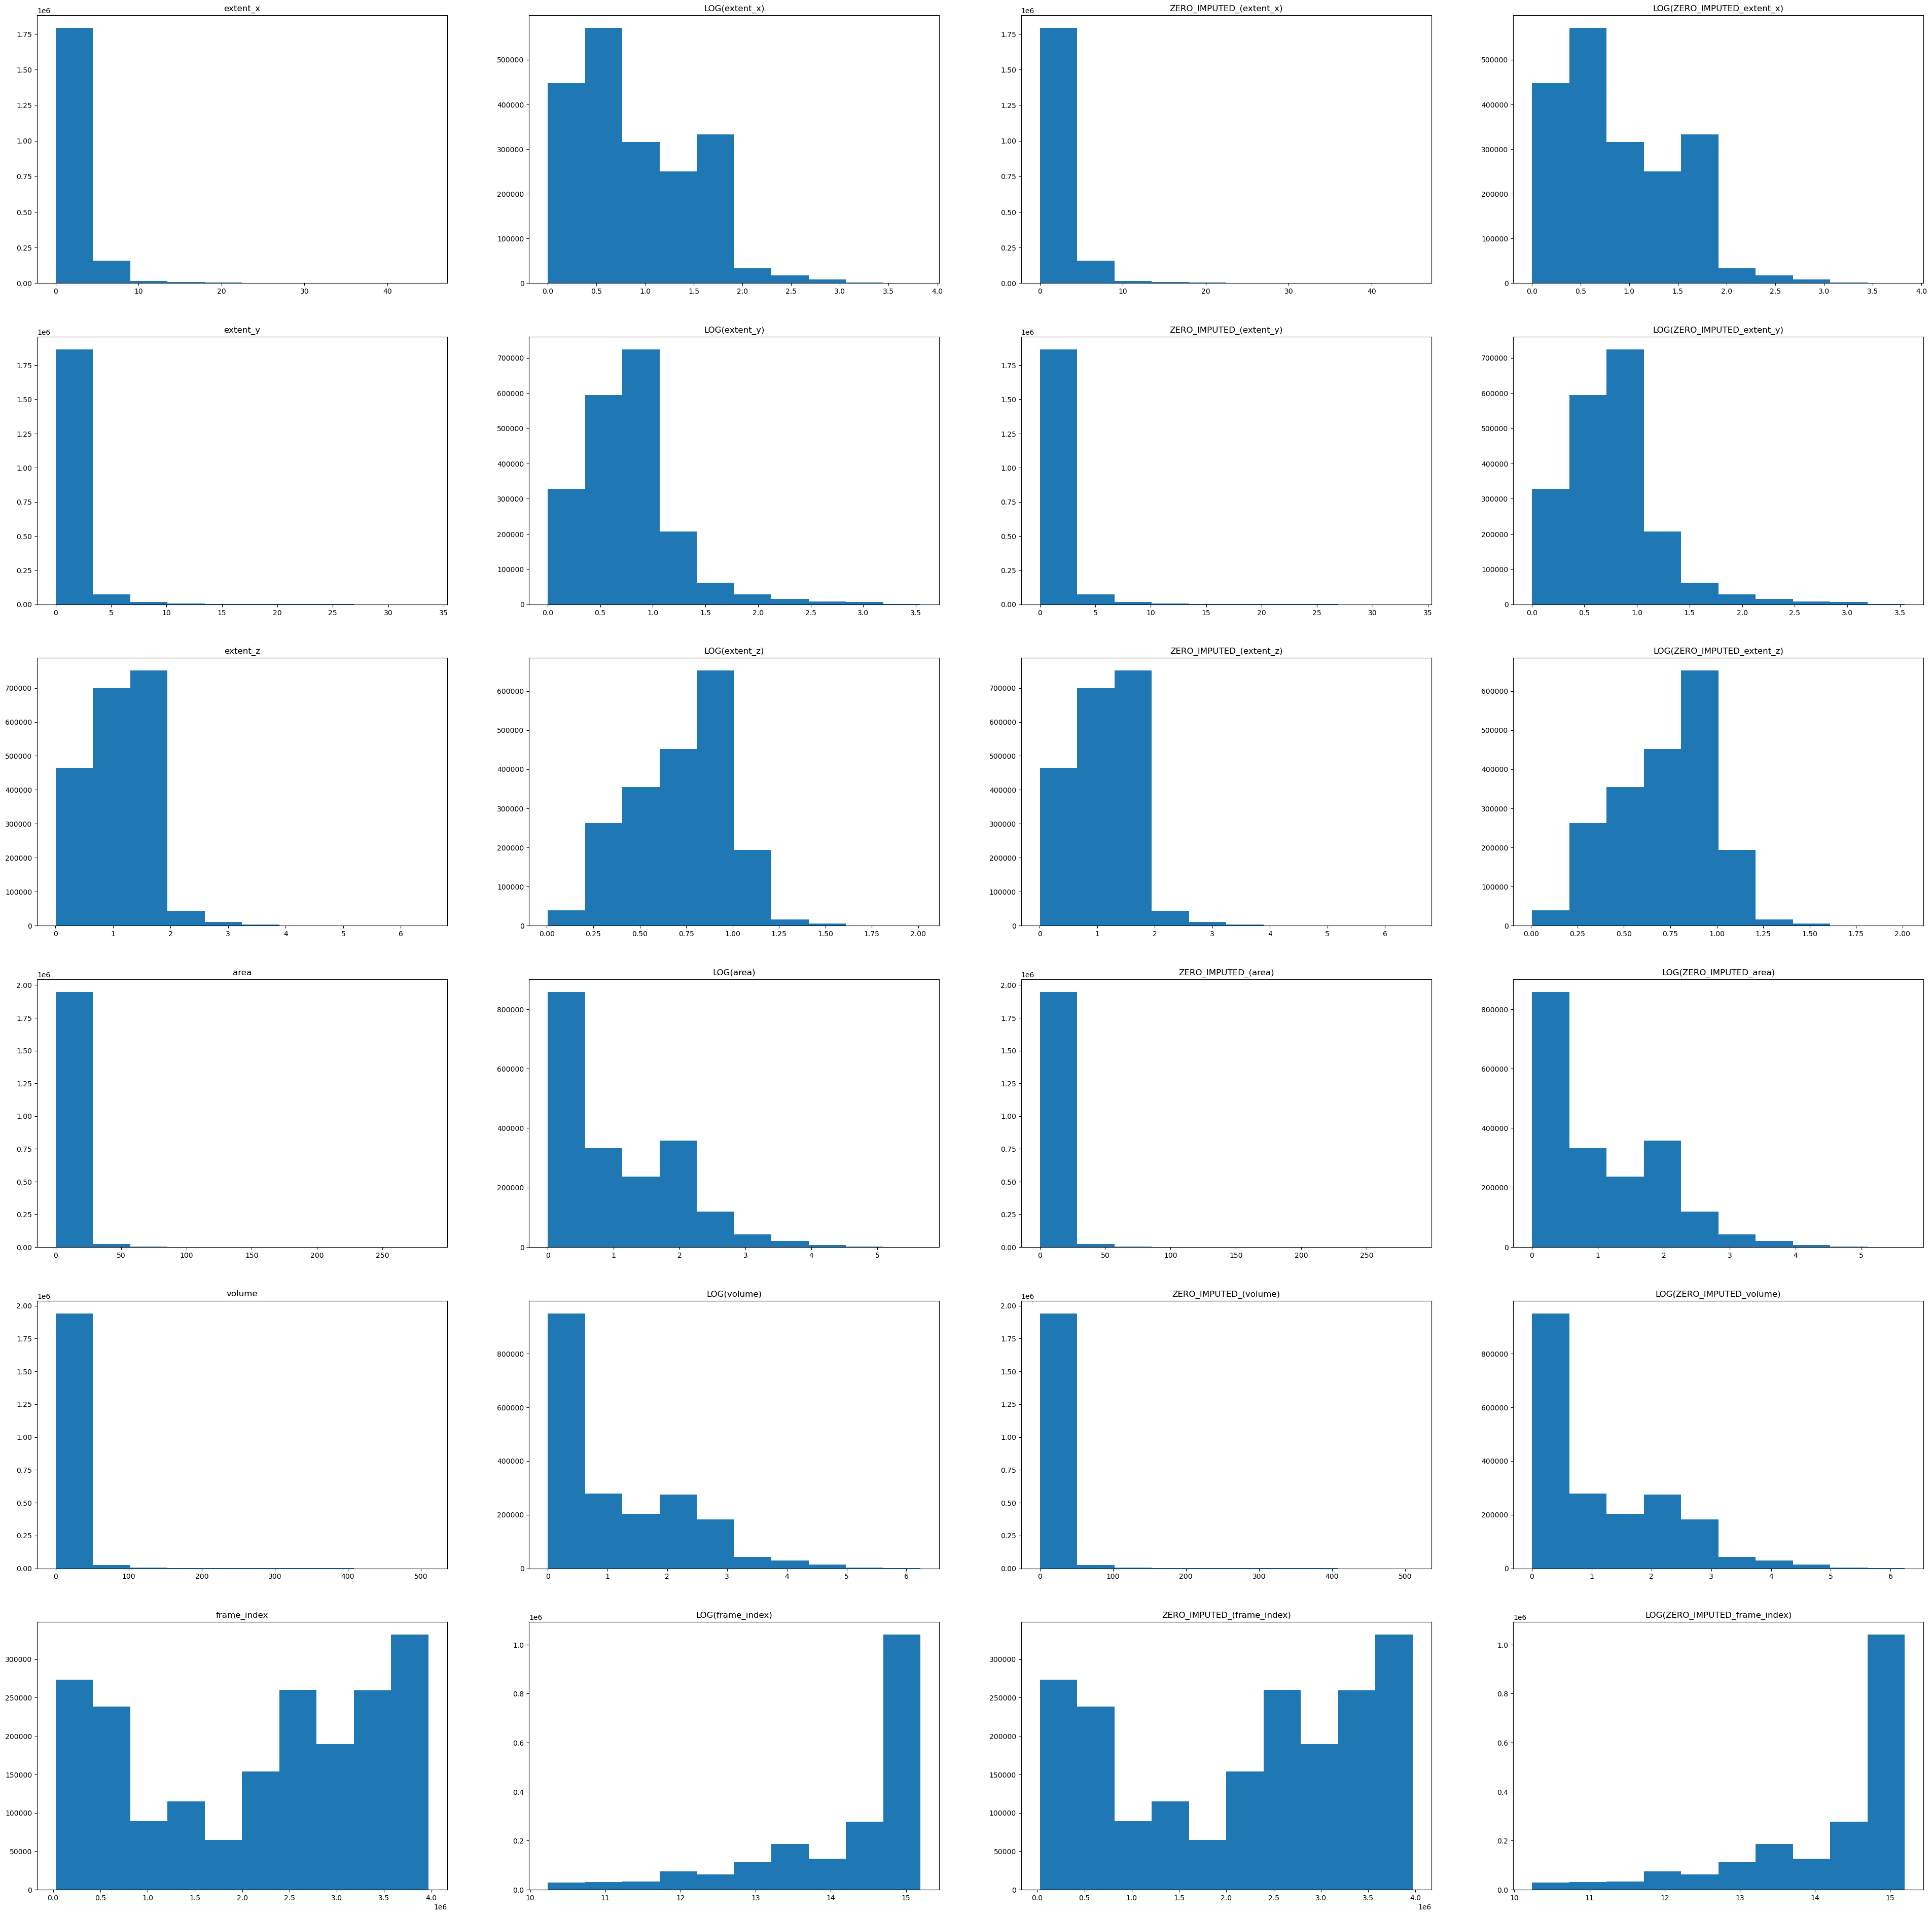

In [58]:
dimension_consistency_column_names = list(dimension_consistency_aggdict.keys())
num_dimension_consistency_column_names = len(dimension_consistency_column_names)
fig, axs = plt.subplots(num_dimension_consistency_column_names,4, 
                        figsize=(num_dimension_consistency_column_names*8,num_dimension_consistency_column_names*8))
for i in range(num_dimension_consistency_column_names):
    temp_column_name = dimension_consistency_column_names[i]
    axs[i][0].hist(df[temp_column_name])
    axs[i][0].set_title(temp_column_name)
    
    axs[i][1].hist(np.log1p(df[temp_column_name].values))
    axs[i][1].set_title("LOG({0})".format(temp_column_name))
    
    axs[i][2].hist((df[temp_column_name].fillna(0).values))
    axs[i][2].set_title("ZERO_IMPUTED_({0})".format(temp_column_name))
    
    axs[i][3].hist(np.log1p(df[temp_column_name].fillna(0).values))
    axs[i][3].set_title("LOG(ZERO_IMPUTED_{0})".format(temp_column_name))

In [59]:
agg_funcs_list = np.mean
dimension_averager_aggdict = {
    "extent_x": agg_funcs_list,
    "extent_y": agg_funcs_list,
    "extent_z": agg_funcs_list,
}
dimension_averager_agg = df.groupby(["scene_index","track_id"], 
                                             as_index=False).agg(dimension_averager_aggdict)
dimension_averager_agg.rename(columns={
    "extent_x": "extent_x_f",
    "extent_y": "extent_y_f",
    "extent_z": "extent_z_f",
},inplace=True)
# redo every dimension-derived column with the new mean-standardized dimensions
extent_x_f_column = dimension_averager_agg["extent_x_f"]
extent_y_f_column = dimension_averager_agg["extent_y_f"]
extent_z_f_column = dimension_averager_agg["extent_z_f"]

dimension_averager_agg["area_f"] = extent_x_f_column*extent_y_f_column
dimension_averager_agg["volume_f"] = dimension_averager_agg["area_f"]*extent_z_f_column
dimension_averager_agg["extent_x_f/extent_y_f"] = (extent_x_f_column+1)/(extent_y_f_column+1)
dimension_averager_agg["extent_y_f/extent_x_f"] = (extent_y_f_column+1)/(extent_x_f_column+1)
dimension_averager_agg["rectangular_f"] = (
    (np.max(dimension_averager_agg[["extent_x_f","extent_y_f"]],axis=1)+1
    )/(np.min(dimension_averager_agg[["extent_x_f","extent_y_f"]],axis=1)+1)
)
dimension_averager_agg["invalid_dims_f"] = 0
dimension_averager_agg.loc[((extent_x_f_column>extent_y_f_column) & (extent_x_f_column > 19.8)),"invalid_dims_f"] = 1
dimension_averager_agg.loc[((extent_x_f_column>extent_y_f_column) & (extent_y_f_column > 2.6)),"invalid_dims_f"] = 1
dimension_averager_agg.loc[((extent_y_f_column>extent_x_f_column) & (extent_y_f_column > 19.8)),"invalid_dims_f"] = 1
dimension_averager_agg.loc[((extent_y_f_column>extent_x_f_column) & (extent_x_f_column > 2.6)),"invalid_dims_f"] = 1
print("track-id-wise invalid_dims_f percentage", np.mean(dimension_averager_agg["invalid_dims_f"]))
print("original invalid_dims percentage", np.mean(df["invalid_dims"]))

track-id-wise invalid_dims_f percentage 0.03268452741231563
original invalid_dims percentage 0.030531421512040018


In [60]:
df1 = df.copy()

In [61]:
df = df.merge(dimension_averager_agg,on=["scene_index","track_id"])
df["norm/volume_f"] = (df["norm"]+1)/(df["volume_f"]+1)
df["norm/area_f"] = (df["norm"]+1)/(df["area_f"]+1)

### Preparing Imputation of Label Unknown by Checking Features Associated with Certain Labels

In [62]:
df_agent_type_categorizer_column_names = [
    "extent_x",
    "extent_y",
    "extent_z",
    "norm",
    "area",
    "volume",
    "extent_x/extent_y",
    "extent_y/extent_x",
    "rectangular",
    "on_road",
    "on_crosswalks",
    "norm/volume",
    "norm/area",
    
    "extent_x_f",
    "extent_y_f",
    "extent_z_f",
    "area_f",
    "volume_f",
    "extent_x_f/extent_y_f",
    "extent_y_f/extent_x_f",
    "rectangular_f",
    "norm/volume_f",
    "norm/area_f",
]

df_agent_type_categorizer = df[df_agent_type_categorizer_column_names]

In [63]:
df_agent_type_categorizer_corr = pd.concat([df_agent_type_categorizer,df[agent_type_column_names]], axis=1)
df_agent_type_categorizer_corr.corr()[agent_type_column_names]

,label_car,label_ped,label_cyc,label_unk
extent_x,0.459950,-0.104274,-0.022064,-0.414608
extent_y,0.032855,-0.075074,-0.033936,-0.003893
extent_z,0.143916,0.059485,0.026963,-0.163306
norm,0.445064,-0.029866,0.014537,-0.428480
area,0.200510,-0.072840,-0.029367,-0.169378
volume,0.157047,-0.055361,-0.022664,-0.133239
extent_x/extent_y,0.373762,-0.068455,0.013730,-0.346521
extent_y/extent_x,-0.278768,0.000348,-0.028917,0.276940
rectangular,0.128560,-0.100204,-0.018456,-0.091962
on_road,0.254795,-0.016129,0.031819,-0.248962


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [65]:
model_input_column_names = df_agent_type_categorizer_column_names
model_output_column_name = "label"
df_known = df[df["label"]!="label_unk"]
df_unknown = df[df["label"]=="label_unk"]


#df_known["label"].value_counts().idxmin()
min_category_size = df_known["label"].value_counts().min()
known_labels = list(df_known["label"].value_counts().index)
df_known_resampled_list = []
for temp_label in known_labels:
    df_known_temp_label = df_known[df_known["label"]==temp_label]
    df_known_temp_label_sampled = df_known_temp_label.sample(n=min_category_size)
    df_known_resampled_list.append(df_known_temp_label_sampled)
df_known_resampled = pd.concat(df_known_resampled_list, axis=0)
df_known_resampled_reshuffled = df_known_resampled.sample(frac=1)
df_known_model_table = df_known_resampled_reshuffled[model_input_column_names+[model_output_column_name]]
X = df_known_model_table[model_input_column_names] # use df_known_model_table, not df or df_known
y = df_known_model_table[model_output_column_name] # use df_known_model_table, not df or df_known
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, random_state=42)

model = LogisticRegression()
#model = RandomForestClassifier(3)
model.fit(X_train, y_train)

#df_unknown = df[df["label"]=="label_unk"]

C:\Users\Benson\anaconda3\envs\lyft_summer_2023\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [66]:
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(X_test)
print(np.mean(test_predictions==y_test))
confusion_matrix_arr = confusion_matrix(y_test, test_predictions)
confusion_matrix_arr

0.9628686327077748


array([[2436,   36,   14],
       [  26, 2318,  143],
       [  15,   43, 2429]], dtype=int64)

In [ ]:
#model_feature_importances
model_feature_importances_ranked = pd.Series(
    index=model_input_column_names,
    data=model_feature_importances
).sort_values(ascending=False)
model_feature_importances_ranked.plot(kind="barh")

In [67]:
# see labels for the known categories
X_known = df_known[model_input_column_names]
labels_imputed_column = model.predict(X_known)
labels_imputed_column = df_known["label"]
df_known["label_imputed"] = labels_imputed_column

print(np.mean(labels_imputed_column==df_known["label"]))
confusion_matrix_arr = confusion_matrix(df_known["label"], labels_imputed_column,normalize="true")
np.round(confusion_matrix_arr,2)

C:\Users\Benson\AppData\Local\Temp\ipykernel_19132\985867578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known["label_imputed"] = labels_imputed_column


1.0


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [68]:
# see labels for the unknown categories
df_unknown = df[df["label"]=="label_unk"]
X_unknown = df_unknown[model_input_column_names]
labels_imputed_column = model.predict(X_unknown)
df_unknown["label_imputed"] = labels_imputed_column

C:\Users\Benson\AppData\Local\Temp\ipykernel_19132\3602615381.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unknown["label_imputed"] = labels_imputed_column


In [69]:
df = pd.concat([df_known, df_unknown],axis=0)
df = df.sort_values(["scene_index","track_id","frame_index"])

### From this point onward, no more alterations (e.g. new columns, row removal) should be done to the table

In [70]:
df.to_csv(path_file_lyft_data_new,index=False) 

## Checking Consecutive Appearances of Agents

In [71]:
(df["skip"]).max()

1.0

**It seems like skipped-frames isn't something to be worried about**

In [72]:
(
    (df["skip"]).isnull().sum(),
    df[["scene_index","track_id"]].drop_duplicates().shape[0]
)

(125564, 125564)

In [73]:
df.groupby(["scene_index","track_id"])["frame_index"].count().value_counts().head(20)

frame_index
3     25389
4     17305
1      9908
5      8295
6      6581
7      5269
8      4116
9      3648
10     3080
11     2649
2      2395
12     2294
13     2041
14     1993
15     1640
16     1580
17     1418
18     1243
19     1170
20     1070
Name: count, dtype: int64

**The most common appearance amount of a given agent in a scene is 3 frames. This means our choice of a frame-rate of 3 may pose as a bit of a problem**

## Checking Distributions of Variants for Yaw Column

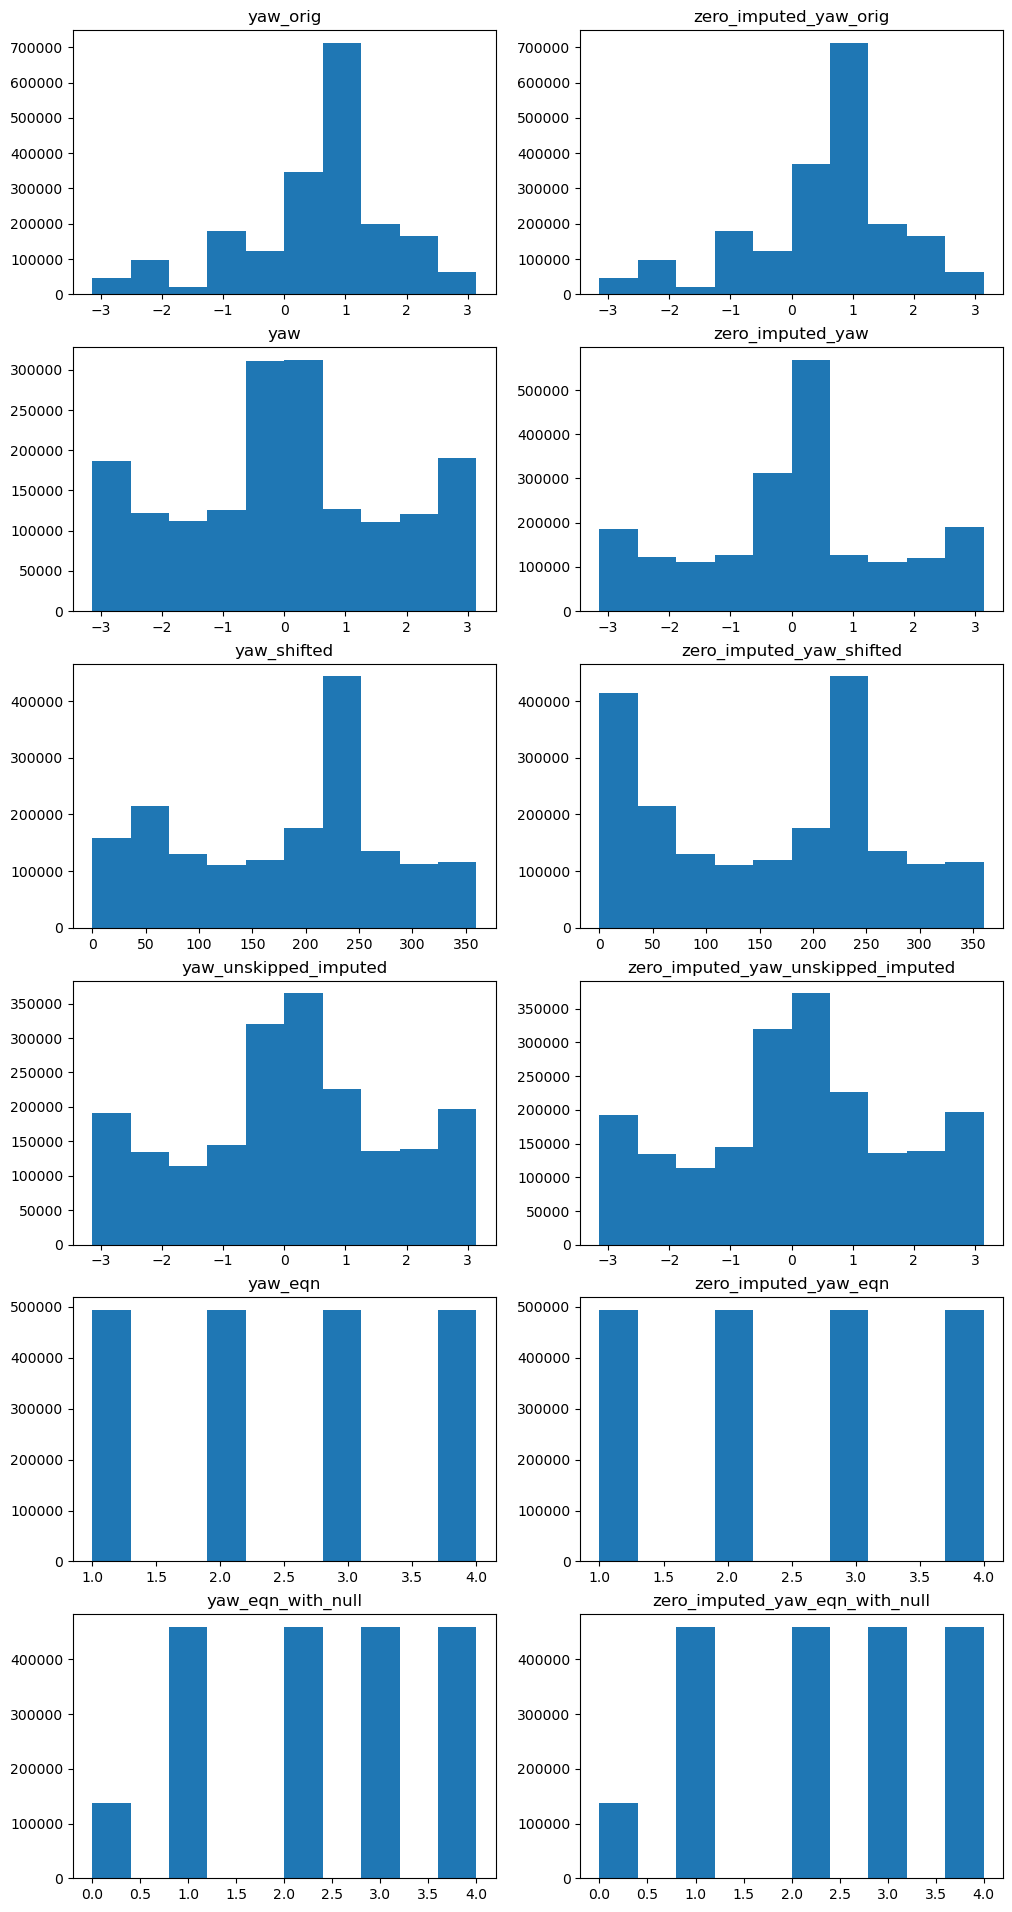

In [74]:
yaw_column_names = ["yaw_orig","yaw","yaw_shifted","yaw_unskipped_imputed","yaw_eqn", "yaw_eqn_with_null"]
num_yaw_column_names = len(yaw_column_names)
fig, axs = plt.subplots(num_yaw_column_names,2, figsize=(num_yaw_column_names*2,num_yaw_column_names*4))
for i in range(num_yaw_column_names):
    temp_column_name = yaw_column_names[i]
    axs[i][0].hist(df[temp_column_name])
    axs[i][0].set_title(temp_column_name)
    axs[i][1].hist(df[temp_column_name].fillna(0))
    axs[i][1].set_title("zero_imputed_{0}".format(temp_column_name))

* **It should be known that location-dependent calculated columns (such as velocity and yaw) will be mostly null if there is no movement (i.e. the length of the translation vector, or norm, is 0).**
* **Here, the exact rows with the problematic null's for yaw are the exact same rows where there is no movement in the agent (i.e. norm is 0)**

In [75]:
np.mean((df["yaw"].isnull().astype(int))==((df["norm"]==0).astype(int)))
# if framerate == 3, this would be 88%
# if framerate == 1, this would be 94%
# Thus, it is necessary to treat non-moving as its own yaw-tier

0.9400702756344047

In [76]:
np.mean(df["norm"]==0)

0.06964376126536646

### As a result, making the null yaws to be their own ordinal category is likely a good idea. 
* **When frame-rate is 1, this category isn't that much compared to the other NTILE yaw_shifted categories**
* **But when frame-rate is 3, the null-yaw category is roughly 20%, which is roughly equal enough to the other 4 yaw categories (also roughly 25% of 80 aka 20%)**

In [77]:
df.groupby(["yaw_eqn_with_null"],as_index=False).agg({"yaw_shifted": [min,max]})

yaw_eqn_with_null yaw_shifted            
                            min         max
0                 0         NaN         NaN
1                 1    0.000659   64.929771
2                 2   64.929858  196.413314
3                 3  196.413523  235.157270
4                 4  235.157358  360.000000

In [78]:
df["yaw_eqn_with_null"].value_counts()

yaw_eqn_with_null
1    459382
3    459382
4    459382
2    459382
0    137552
Name: count, dtype: int64

In [79]:
scene_10522 = df[df["scene_index"]==10522]
scene_10522_selected = scene_10522[
    ((scene_10522["frame_index"]>=2613440) & (scene_10522["frame_index"]<=2613470))]

scene_10522_selected = scene_10522_selected[
    (
        ((scene_10522_selected["centroid_x"]>=726-75) & (scene_10522_selected["centroid_x"]<=726+75)
        )&(
         (scene_10522_selected["centroid_y"]>=-510-75) & (scene_10522_selected["centroid_y"]<=-510+75))
    )]
non_ai_scene_10522_selected = scene_10522_selected[scene_10522_selected["track_id"] != 0]
non_ai_scene_10522_selected

,scene_index,frame_index,track_id,frame_index0,skip,centroid_x,centroid_y,extent_x,extent_y,extent_z,...,extent_z_f,area_f,volume_f,extent_x_f/extent_y_f,extent_y_f/extent_x_f,rectangular_f,invalid_dims_f,norm/volume_f,norm/area_f,label_imputed
1037951,10522,2613440,1,2613439.0,1.0,726.7709,-510.1477,4.535802,2.174328,1.532195,...,1.531062,9.517125,14.571305,1.767427,0.565794,1.767427,0,0.074993,0.111032,label_car
1037952,10522,2613441,1,2613440.0,1.0,726.7053,-510.2250,4.738658,2.141855,1.532515,...,1.531062,9.517125,14.571305,1.767427,0.565794,1.767427,0,0.096775,0.143282,label_car
1037953,10522,2613442,1,2613441.0,1.0,726.7161,-510.1851,4.662959,2.123780,1.539951,...,1.531062,9.517125,14.571305,1.767427,0.565794,1.767427,0,0.077494,0.114735,label_car
1037954,10522,2613443,1,2613442.0,1.0,726.7176,-510.1582,4.617666,2.110039,1.541118,...,1.531062,9.517125,14.571305,1.767427,0.565794,1.767427,0,0.072872,0.107892,label_car
1037955,10522,2613444,1,2613443.0,1.0,726.7192,-510.1337,4.574620,2.106158,1.543943,...,1.531062,9.517125,14.571305,1.767427,0.565794,1.767427,0,0.072104,0.106756,label_car
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057237,10522,2613469,703,NaN,NaN,710.0456,-514.3391,5.483588,5.739060,1.752876,...,1.752876,31.470641,55.164141,0.962091,1.039403,1.039403,1,0.017805,0.030797,label_car
1057238,10522,2613470,704,NaN,NaN,705.1859,-491.1950,4.308316,1.765152,1.591236,...,1.591236,7.604834,12.101082,1.919719,0.520910,1.919719,0,0.076330,0.116214,label_car
1057239,10522,2613470,705,NaN,NaN,726.6713,-541.8419,5.337019,1.989876,1.973107,...,0.488603,0.629440,0.307547,1.382433,0.723362,1.382433,0,0.764791,0.613708,label_car
1057244,10522,2613470,706,NaN,NaN,709.8716,-514.1918,5.476756,6.181531,1.753250,...,1.753250,33.854737,59.355822,0.901863,1.108816,1.108816,1,0.016568,0.028691,label_car


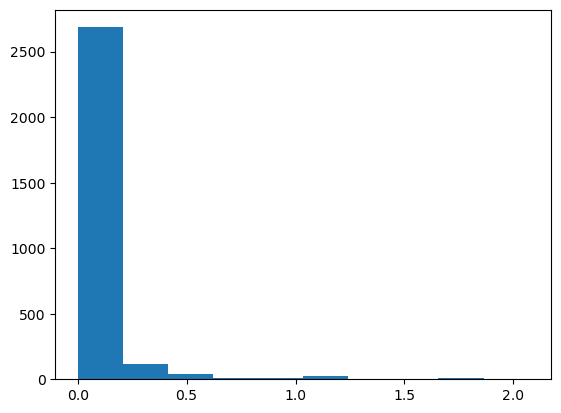

In [80]:
_ = plt.hist(non_ai_scene_10522_selected["norm"]/5)

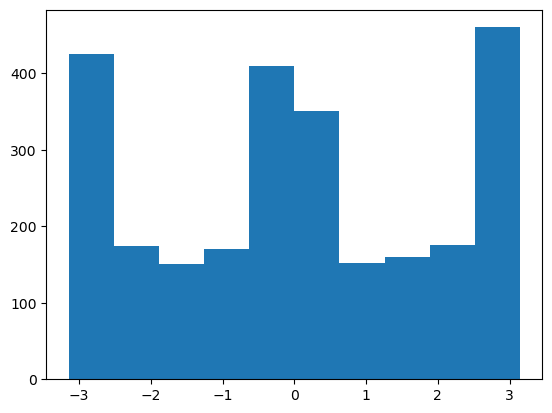

In [81]:
_ = plt.hist(non_ai_scene_10522_selected["yaw"])

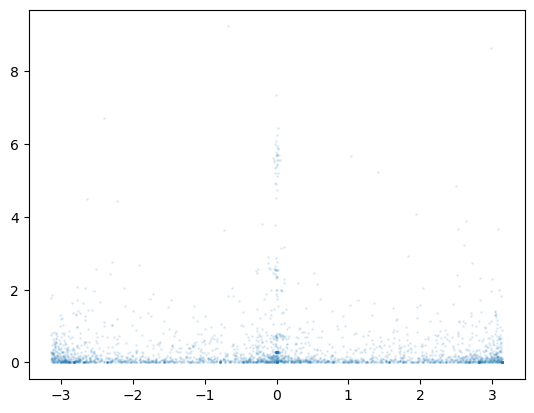

In [82]:
plt.scatter(non_ai_scene_10522_selected["yaw"],non_ai_scene_10522_selected["norm"],alpha=0.1,s=1)

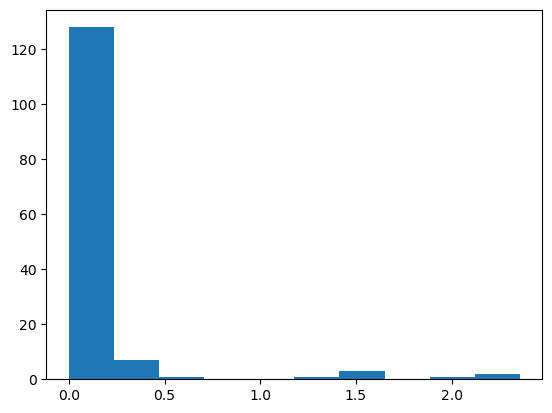

In [83]:
yaw_orig_variation_checker = non_ai_scene_10522_selected.groupby(["track_id"]).agg({"yaw": np.std, 
                                                       "yaw_orig": np.std,
                                                       "frame_index": "count",
                                                       
                                                      })
_ = plt.hist(yaw_orig_variation_checker["yaw_orig"])

0.3024390243902439


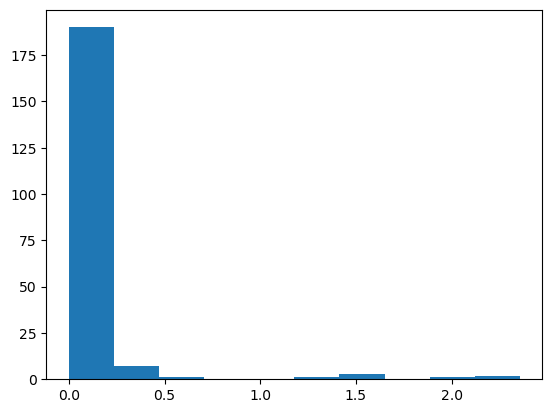

In [84]:
print(yaw_orig_variation_checker["yaw_orig"].isnull().mean())
yaw_orig_variation_checker["yaw_orig"].fillna(0, inplace=True)
_ = plt.hist(yaw_orig_variation_checker["yaw_orig"])

In [85]:
(yaw_orig_variation_checker["frame_index"]==1).mean()


0.3024390243902439